# Star Trek TNG - Master Clean Up 
---
## INTRODUCTION

- What is Star Trek? (a short history lesson)

- Goal: Determine the best roster of characters using NLP and sentiment analysis to predict the highest rating on IMDB. 
    - Elaborate on applications in the real world. 

- Data Acquistition (link to GitHub) 

- Goal in this notebook is to clean the dataset, and preprocess it for modeling, along with some handy visualizations. 



   

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 


In [33]:
# read in the dataset
startrek_data = pd.read_csv(r'C:\Users\Katya\Documents\data\TNG.csv.gz', encoding= 'latin-1')

In [34]:
# taking a quick peek at the data
startrek_data.shape

(110176, 18)

In [35]:
startrek_data.head()

,Unnamed: 0,episode,productionnumber,setnames,characters,act,scenenumber,scenedetails,partnumber,type,who,text,speechdescription,Released,Episode,imdbRating,imdbID,Season
0,1,encounter at farpoint,NaN,NaN,NaN,TEASER,1,NaN,1,description,NaN,The U.S.S. Enterprise NCC 1701-D traveling at...,False,1987-09-26,1.0,6.9,tt0094030,1.0
1,2,encounter at farpoint,NaN,NaN,NaN,TEASER,1,NaN,2,speech,PICARD V.O.,"Captain's log, stardate 42353.7. Our destinat...",False,1987-09-26,1.0,6.9,tt0094030,1.0
2,3,encounter at farpoint,NaN,NaN,NaN,TEASER,2,NaN,3,description,NaN,on the gigantic new Enterprise NCC 1701-D.,False,1987-09-26,1.0,6.9,tt0094030,1.0
3,4,encounter at farpoint,NaN,NaN,NaN,TEASER,2,NaN,4,speech,PICARD V.O.,"My orders are to examine Farpoint, a starbase...",False,1987-09-26,1.0,6.9,tt0094030,1.0
4,5,encounter at farpoint,NaN,NaN,NaN,TEASER,3,NaN,5,description,NaN,"Huge, with a giant wall diagram showing the i...",False,1987-09-26,1.0,6.9,tt0094030,1.0


In [36]:
# filtered to only rows where a charactor spoke in the episode
startrekspeech = startrek_data.loc[startrek_data['type'] == 'speech']

# take a look
startrekspeech.head()

,Unnamed: 0,episode,productionnumber,setnames,characters,act,scenenumber,scenedetails,partnumber,type,who,text,speechdescription,Released,Episode,imdbRating,imdbID,Season
1,2,encounter at farpoint,NaN,NaN,NaN,TEASER,1,NaN,2,speech,PICARD V.O.,"Captain's log, stardate 42353.7. Our destinat...",False,1987-09-26,1.0,6.9,tt0094030,1.0
3,4,encounter at farpoint,NaN,NaN,NaN,TEASER,2,NaN,4,speech,PICARD V.O.,"My orders are to examine Farpoint, a starbase...",False,1987-09-26,1.0,6.9,tt0094030,1.0
5,6,encounter at farpoint,NaN,NaN,NaN,TEASER,3,NaN,6,speech,PICARD V.O.,"acquainted with my new command, this Galaxy C...",True,1987-09-26,1.0,6.9,tt0094030,1.0
7,8,encounter at farpoint,NaN,NaN,NaN,TEASER,4,NaN,8,speech,PICARD V.O.,I am still somewhat in awe of its size and co...,False,1987-09-26,1.0,6.9,tt0094030,1.0
9,10,encounter at farpoint,NaN,NaN,NaN,TEASER,5,NaN,10,speech,PICARD V.O.,"several key positions, most notably ...",True,1987-09-26,1.0,6.9,tt0094030,1.0


In [37]:
StarTrek_Cols = startrekspeech.filter(['episode', 'type', 'who', 'Episode', 'imdbRating', 'Season', 'text'], axis=1)


In [38]:
# check for null/missing values
StarTrek_Cols.isna().sum()

episode         0
type            0
who             1
Episode       748
imdbRating    748
Season        748
text            0
dtype: int64

In [39]:
# show null rows
StarTrek_Cols[StarTrek_Cols.isna().any(axis=1)]

,episode,type,who,Episode,imdbRating,Season,text
75782,time's arrow,speech,PICARD (V.O.),NaN,NaN,NaN,"Captain's log, stardate 45959.1. The Enterpri..."
75783,time's arrow,speech,PICARD (V.O.),NaN,NaN,NaN,All we've been told is that evidence has been...
75785,time's arrow,speech,SCIENTIST,NaN,NaN,NaN,Work crews were down here installing seismic ...
75787,time's arrow,speech,PICARD,NaN,NaN,NaN,And it's been determined that they date back ...
75788,time's arrow,speech,DATA,NaN,NaN,NaN,The biofocal vision aide is typical of the er...
...,...,...,...,...,...,...,...
80979,rascals,speech,GUINAN,NaN,NaN,NaN,Only if you're ready.
80981,rascals,speech,YOUNG RO,NaN,NaN,NaN,It's not quite as bad as I remembered it... b...
80983,rascals,speech,YOUNG RO,NaN,NaN,NaN,We better get going.
80985,rascals,speech,GUINAN,NaN,NaN,NaN,There's no hurry. The Transporter will still ...


In [40]:
# plug in episode, imdbrating and season manually 

#looking up one episode
StarTrek_Cols.loc[StarTrek_Cols['episode'] == "time's arrow"]

,episode,type,who,Episode,imdbRating,Season,text
75782,time's arrow,speech,PICARD (V.O.),NaN,NaN,NaN,"Captain's log, stardate 45959.1. The Enterpri..."
75783,time's arrow,speech,PICARD (V.O.),NaN,NaN,NaN,All we've been told is that evidence has been...
75785,time's arrow,speech,SCIENTIST,NaN,NaN,NaN,Work crews were down here installing seismic ...
75787,time's arrow,speech,PICARD,NaN,NaN,NaN,And it's been determined that they date back ...
75788,time's arrow,speech,DATA,NaN,NaN,NaN,The biofocal vision aide is typical of the er...
...,...,...,...,...,...,...,...
76457,time's arrow,speech,BEVERLY,NaN,NaN,NaN,These strands appear to be biomagnetic... var...
76458,time's arrow,speech,PICARD,NaN,NaN,NaN,A life-form... ?
76461,time's arrow,speech,TROI,NaN,NaN,NaN,No. There is no life here... what I have sens...
76467,time's arrow,speech,RIKER,NaN,NaN,NaN,My God... they're delivering more of them... ...


In [41]:
# plug in values manually (episode: time's arrow)
StarTrek_Cols.at[75782:76468, 'Season'] = int(5)
StarTrek_Cols.at[75782:76468, 'imdbRating'] = 8.4
StarTrek_Cols.at[75782:76468, 'Episode'] = int(26)


In [42]:
StarTrek_Cols.loc[StarTrek_Cols['episode'] == "time's arrow"]

,episode,type,who,Episode,imdbRating,Season,text
75782,time's arrow,speech,PICARD (V.O.),26.0,8.4,5.0,"Captain's log, stardate 45959.1. The Enterpri..."
75783,time's arrow,speech,PICARD (V.O.),26.0,8.4,5.0,All we've been told is that evidence has been...
75785,time's arrow,speech,SCIENTIST,26.0,8.4,5.0,Work crews were down here installing seismic ...
75787,time's arrow,speech,PICARD,26.0,8.4,5.0,And it's been determined that they date back ...
75788,time's arrow,speech,DATA,26.0,8.4,5.0,The biofocal vision aide is typical of the er...
...,...,...,...,...,...,...,...
76457,time's arrow,speech,BEVERLY,26.0,8.4,5.0,These strands appear to be biomagnetic... var...
76458,time's arrow,speech,PICARD,26.0,8.4,5.0,A life-form... ?
76461,time's arrow,speech,TROI,26.0,8.4,5.0,No. There is no life here... what I have sens...
76467,time's arrow,speech,RIKER,26.0,8.4,5.0,My God... they're delivering more of them... ...


In [43]:
# check for more missing values to input
StarTrek_Cols[StarTrek_Cols.isna().any(axis=1)]

,episode,type,who,Episode,imdbRating,Season,text
80403,rascals,speech,PICARD (V.O.),NaN,NaN,NaN,"Captain's Log, Stardate 46235.7 Ensign Ro, Ke..."
80405,rascals,speech,PICARD,NaN,NaN,NaN,the tertiary level of the dig. They're typica...
80407,rascals,speech,GUINAN,NaN,NaN,NaN,Mmmm-hmmmm.
80408,rascals,speech,PICARD,NaN,NaN,NaN,"Now, see these markings... they're very simil..."
80410,rascals,speech,GUINAN,NaN,NaN,NaN,So... you went to one of the most beautiful p...
...,...,...,...,...,...,...,...
80979,rascals,speech,GUINAN,NaN,NaN,NaN,Only if you're ready.
80981,rascals,speech,YOUNG RO,NaN,NaN,NaN,It's not quite as bad as I remembered it... b...
80983,rascals,speech,YOUNG RO,NaN,NaN,NaN,We better get going.
80985,rascals,speech,GUINAN,NaN,NaN,NaN,There's no hurry. The Transporter will still ...


In [44]:
# plug in values manually (episode: Rascals)
StarTrek_Cols.at[80403:80985, 'Season'] = int(6)
StarTrek_Cols.at[80403:80985, 'imdbRating'] = 7.4
StarTrek_Cols.at[80403:80985, 'Episode'] = int(7)

In [45]:
# check for more missing values to input
StarTrek_Cols[StarTrek_Cols.isna().any(axis=1)]

,episode,type,who,Episode,imdbRating,Season,text
86697,birthright: part 2,speech,NaN,17.0,7.3,6.0,van'aj javDIch Qong DIr Sa'VIch ghIH yot quel...


In [46]:
StarTrek_Cols.dropna(inplace=True)

In [47]:
# confirmed no more missing values
StarTrek_Cols.isna().sum()

episode       0
type          0
who           0
Episode       0
imdbRating    0
Season        0
text          0
dtype: int64

In [48]:
# remove leading whitespaces
StarTrek_Cols['who'] = StarTrek_Cols['who'].str.lstrip()

In [49]:
# remove (V.O.) 
# StarTrek_Cols['who'] = StarTrek_Cols['who'].str.replace(r'PICARD(\s*)', '', regex=True)

In [50]:
# StarTrek_Cols['who']= StarTrek_Cols['who'].apply(lambda x: x.split('PICARD')[0])

In [51]:
# # remove whitespaces
# StarTrek_Cols['who'] = StarTrek_Cols['who'].str.replace(' ', '')

In [52]:
# checking the if regex worked
StarTrek_Cols['who'].unique().tolist()

['PICARD V.O.',
 'PICARD',
 'DATA',
 'TROI',
 'WORF',
 'CONN',
 '"Q" (ELIZABETHAN)',
 'MEDIC',
 '"Q" (MARINE CAPTAIN)',
 'PICARD "Q" (MARINE CAPTAIN) PICARD "Q" (MARINE CAPTAIN)',
 '"Q" (21ST CENTURY)',
 'TASHA',
 'PICARD TROI',
 "PICARD'S INTERCOM VOICE",
 'MANDARIN-BAILIFF',
 'FUTURE MILITARY OFFICER',
 'MILITARY OFFICER',
 '"Q" (JUDGE)',
 '"Q" (JUDGE) MANDARIN-BAILIFF',
 'DATA "Q" (JUDGE)',
 'OPS',
 "RIKER'S VOICE",
 'ZORN',
 'RIKER',
 "ZORN ZORN (Cont'd)",
 'WESLEY',
 'BEVERLY',
 'MARKHAM',
 'GEORDI/MARKHAM',
 'GEORDI',
 'BANDI WOMAN',
 "DATA'S VOICE",
 'RIKER (V.O.)',
 'ADMIRAL',
 "PICARD'S VOICE",
 'PICARD WORF',
 "TROI'S VOICE",
 'PICARD ZORN',
 'YOUNG ENSIGN',
 'COMPUTER VOICE',
 'RIKER COMPUTER VOICE',
 'RIKER DATA',
 "WESLEY'S VOICE",
 'PICARD WES',
 'BEVERLY WESLEY',
 "TASHA'S VOICE",
 'WES',
 'SECURITY VOICE',
 "ZORN'S VOICE",
 'SECURITY POSITION',
 'OPERATIONS POSITION',
 "ZORN'S VOICE PICARD",
 'INTERCOM VOICE',
 '"Q" (STARFLEET)',
 'PICARD RIKER',
 'PICARD TASHA',
 'PICA

# To Do 

Filter the dataset to only have these characters:

- Main Characters:
    - Jean-Luc Picard
    - William Riker
    - Geordi La Forge
    - Tasha Yar
    - Worf
    - Beverly Crusher
    - Deanna Troi
    - Data
    - Wesley Crusher
    - Katherine Pulaski
    - Q
    - Lore

In [53]:
# create a list of characters (TEST)
characters = ['PICARD','WORF', 'BEVERLY', 'GEORDI', 'TROI', 'TASHA', 'DATA', 'WESLEY', 'PULASKI', 'Q', 'RIKER', 'LORE']

# filtering to only the characters in the list above
StarTrek_Final = StarTrek_Cols[StarTrek_Cols['who'].isin(characters)].copy()

In [54]:
# checking to see if the values are correct
StarTrek_Final['who'].unique()

array(['PICARD', 'DATA', 'TROI', 'WORF', 'TASHA', 'RIKER', 'WESLEY',
       'BEVERLY', 'GEORDI', 'LORE', 'PULASKI', 'Q'], dtype=object)

In [55]:
StarTrek_Final.shape

(44600, 7)

In [56]:
StarTrek_Final.loc[StarTrek_Cols['who'].isin(characters)]

,episode,type,who,Episode,imdbRating,Season,text
12,encounter at farpoint,speech,PICARD,1.0,6.9,1.0,"You will agree, Data, that Starfleet's instru..."
13,encounter at farpoint,speech,DATA,1.0,6.9,1.0,Difficult ... how so? Simply solve the myster...
14,encounter at farpoint,speech,PICARD,1.0,6.9,1.0,As simple as that.
15,encounter at farpoint,speech,TROI,1.0,6.9,1.0,Farpoint Station. Even the name sounds myster...
16,encounter at farpoint,speech,PICARD,1.0,6.9,1.0,"The problem, Data, is that another life form ..."
...,...,...,...,...,...,...,...
110167,all good things...,speech,DATA,25.0,8.5,7.0,Would you care to deal?
110168,all good things...,speech,PICARD,25.0,8.5,7.0,Oh... thank you.
110170,all good things...,speech,PICARD,25.0,8.5,7.0,I should have done this a long time ago. I wa...
110171,all good things...,speech,TROI,25.0,8.5,7.0,You were always welcome.


In [57]:
# rounding the imdb rating to ensure accuracy of the data
StarTrek_Final['imdbRating'] = round(StarTrek_Final['imdbRating'])

In [58]:
# converting the decimal values to integers
StarTrek_Final['imdbRating'] = StarTrek_Final['imdbRating'].astype('int')

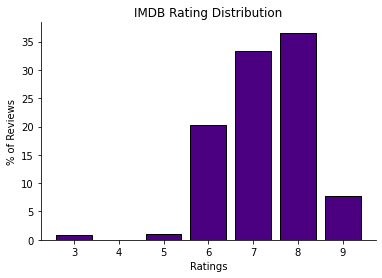

In [60]:
# looking at the distribution of the IMDB Ratings 
values, counts = np.unique(StarTrek_Final['imdbRating'], return_counts=True,)
normalized_reviews = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_reviews * 100, edgecolor='black', color='indigo')
plt.xlabel('Ratings')
plt.ylabel('% of Reviews')
sns.despine()
plt.title("IMDB Rating Distribution")
plt.show()